In [18]:
import sys
from math import cos, pi, sin, sqrt

import numpy as np
import sympy as sym
from matplotlib import pyplot as plt
from sympy.utilities import lambdify

location = "/home/gsalinas/GitHub/MyTransport/PyTransport" # This should be the location of the PyTransport folder folder
sys.path.append(location) # Sets up python path to give access to PyTransSetup

import PyTransSetup

PyTransSetup.pathSet()  # This adds the other paths that PyTransport uses to the python path

import PyTransD5 as PyT
import PyTransScripts as PyS

In [38]:
nF = 2  # number of fields
nP = 10  # number of parameters
f = sym.symarray('f',nF)   # an array representing the nF fields present for this model [phi, chi]
p = sym.symarray('p',nP)   # an array representing the nP parameters needed to define this model, format [Num, g, l, u, q, a0, a1, b1, p, V0]

L = (27 * pi / 4 * p[0] * p[1] * p[2] ** 4)**0.25
mu = ((2*pi)**5 * p[2]**6)**(-1)
T5 = mu / p[1]
gamma = 4 * pi**2 * p[2]**2 * p[-2] * p[4] * T5 * p[1]
rho = f[0] / 3 / p[3]

H = (L / 3 / p[3])**4 * (2 / rho**2 - 2 * sym.log(1/rho**2 + 1))
F = H / 9 * (f[0]**2 + 3*p[3]**2)**2 + (pi * p[2]**2 * p[4])**2
Phi = 5 / 72 * (81 * (9 * rho**2 - 2) * rho**2 + 162 * sym.log(9*(rho**2 + 1)) - 9 - 160*sym.log(10))
PhiH = p[5] * (2/rho**2 - 2*sym.log(1/rho**2 + 1)) + 2 * p[6] * (6 + 1/rho**2 - 2*(2+3*rho**2)*sym.log(1+1/rho**2))*sym.cos(f[1]) \
    + p[-3] / 2 * (2+3*rho**2) * sym.cos(f[1])

V = p[-1] + 4*pi*p[-2]*T5/H*(sym.sqrt(F)-p[2]**2*pi*p[4]*p[1])+gamma*(Phi+PhiH)   # this is the potential written in sympy notation
G = 4*pi*p[-2]*T5*sym.sqrt(F) * sym.Matrix([[(f[0]**2+6*p[3]**2)/(f[0]**2+9*p[3]**2), 0], [0, 1/6*(f[0]**2+6*p[3]**2)]]) # this is the field metric written in sympy notation

In [19]:
nF=PyT.nF()
nP=PyT.nP()

Num, g, l, q, a0, a1, b1 = 1000, 0.01, 501.961, 1, 0.001, 0.0005, 0.001
p, V0 = 5, -1.177572470868058e-8
pval = np.array([Num, g, l, 50*l, q, a0, a1, b1, p, V0])
fields = np.array([4, 0.95])

In [20]:
V = PyT.V(fields, pval) # Calculate potential from some initial conditions
dV = PyT.dV(fields, pval) # Calculate derivatives of potential

phidot0 = np.zeros(2) # set initial conditions to be in slow roll
initial = np.concatenate((fields, phidot0)) # Sets an array containing field values and there derivative in cosmic time 

In [21]:
Nstart, Nend = 0., 83.47
Nrange = np.linspace(Nstart, Nend, 1_000)

tols = np.array([10**-10, 10**-10])
back = PyT.backEvolve(Nrange, initial, pval, tols, False)

In [22]:
Ns, phis, phidots =  back.T[0], back.T[1:nF+1], back.T[nF+1:]

In [23]:
Nend = Ns[-1]
print(f'Number of e-folds: {Nend:.3}')

Number of e-folds: 83.5


[20, 30, 0.95, 3.5]

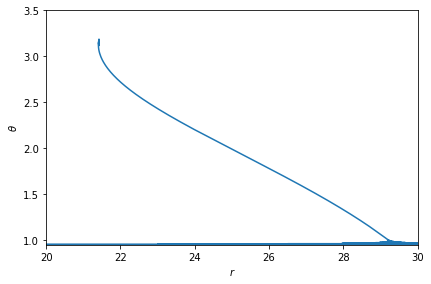

In [24]:
plt.plot(phis[0], phis[1])
plt.xlabel(r'$r$')
plt.ylabel(r'$\theta$')
plt.tight_layout()
plt.axis([20, 30, 0.95, 3.5])

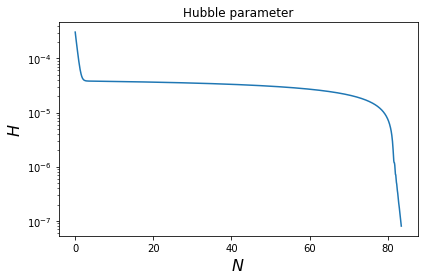

In [25]:
Hs = np.array([PyT.H(elem, pval) for elem in back[:, 1:]])
plt.plot(Ns, Hs)
plt.title('Hubble parameter')
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'$H$', fontsize=16)
plt.yscale('log')
plt.tight_layout()

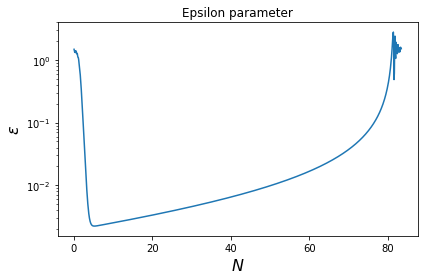

In [26]:
dN = Ns[1] - Ns[0]
epsilon = -np.gradient(Hs, dN)/Hs
plt.plot(Ns, epsilon)
plt.title('Epsilon parameter')
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'$\epsilon$', fontsize=16)
plt.yscale('log')
plt.tight_layout()

In [27]:
NExit = Nend - 55
k = PyS.kexitN(NExit, back, pval, PyT) 

print(f'Horizon exit at N = {NExit:.3} with k = {k:.3}')

Horizon exit at N = 28.5 with k = 8.16e+07


In [28]:
NB = 6.0
Nstart, backExitMinus = PyS.ICsBE(NB, k, back, pval, PyT) # find conditions for NB e-folds before horizon crossing of k mode

print(f"2-pt calculation starts at: {Nstart:.3} e-folds")

2-pt calculation starts at: 22.4 e-folds


In [29]:
Nsig = Ns[Ns > Nstart]

# run the sigma routine to calc and plot the evolution of power spectrum value for this k -- can be
# repeated to build up the spectrum, here we run twice to get an crude estimate for ns
twoPt = PyT.sigEvolve(Nsig, k, backExitMinus, pval, tols, True) # puts information about the two point fuction in twoPt array
Nssig = twoPt[:, 0]
Pzeta = twoPt[:, 1] # the second column is the 2pt of zeta
sigma = twoPt[:, 1+1+2*nF:] # the last 2nF* 2nF columns correspond to the evolution of the sigma matrix

In [30]:
twoPt2 = PyT.sigEvolve(Nsig, k+.1*k, backExitMinus, pval, tols, True)
Pzeta2 = twoPt2[:,1]
n_s = (np.log(Pzeta2[-1])-np.log(Pzeta[-1])) / (np.log(k+.1*k)-np.log(k)) + 4.0
print(f'n_s: {n_s:.3f}')

n_s: 0.953


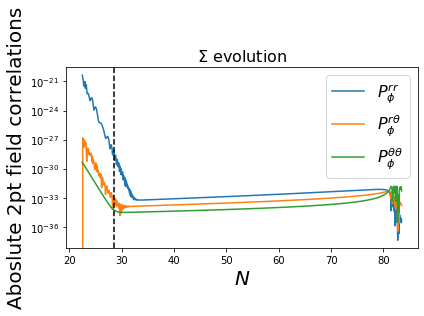

In [31]:
pairs = [(0,0), (0,1), (1,1)]
labels = ['$P^{rr}_\\phi$', '$P^{r\\theta}_\\phi$', '$P^{\\theta\\theta}_\\phi$']
for ii, pair in enumerate(pairs):
    plt.plot(Nssig, np.abs(sigma[:, pair[0] + 2*nF*pair[1]]), label=labels[ii])
plt.title(r'$\Sigma$ evolution',fontsize=16)
plt.legend(fontsize=16)
plt.ylabel(r'Aboslute 2pt field correlations', fontsize=20) 
plt.xlabel(r'$N$', fontsize=20)
plt.yscale('log')
plt.axvline(NExit, c='k', linestyle='--')
plt.tight_layout()

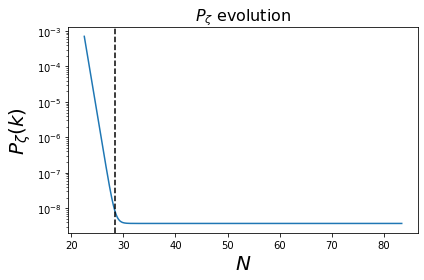

In [33]:
Pzeta_nodim = Pzeta * k**3 / 2 / np.pi**2
plt.plot(Nssig, Pzeta_nodim)
plt.axvline(NExit, c='k', linestyle='--')
plt.title(r'$P_\zeta$ evolution',fontsize=16);
plt.ylabel(r'$P_\zeta(k)$', fontsize=20) 
plt.xlabel(r'$N$', fontsize=20)
plt.yscale('log')
plt.tight_layout()

In [34]:
print(f'k: {k:.3}')
print(f'Power spectrum: {Pzeta_nodim[-1]:.3}')

i_exit_sig = np.argmin(np.abs(Nssig - NExit))
print(f'Power spectrum at horizon crossing: {Pzeta_nodim[i_exit_sig]:.3}')

k: 8.16e+07
Power spectrum: 3.74e-09
Power spectrum at horizon crossing: 7.3e-09


In [35]:
def dot_G(G_lbd, v1, v2, phi):
    return np.matmul(v1, np.matmul(G_lbd(phi[0], phi[1]), v2))

def mag_G(G_lbd, v, phi):
    return np.sqrt(dot_G(G_lbd, v, v, phi))

def e_pll(G_lbd, phi, phidot):
    return phidot / mag_G(G_lbd, phidot, phi)

def e_perp(G_lbd, phi, phidot):
    epll = e_pll(G_lbd, phi, phidot)
    e_perp_not_norm = np.array([epll[1], -epll[0]])
    return e_perp_not_norm / mag_G(G_lbd, e_perp_not_norm, phi)

In [43]:
G_lbd = lambdify(['f_0', 'f_1'], G.subs([('p_'+str(ii), pval[ii]) for ii in range(len(pval))]))

eplls = np.array([e_pll(G_lbd, phis.T[ii], phidots.T[ii]) for ii in range(len(phis.T))])
eperps = np.array([e_perp(G_lbd, phis.T[ii], phidots.T[ii]) for ii in range(len(phis.T))])

/tmp/ipykernel_2959566/2888876044.py:8: RuntimeWarning: invalid value encountered in true_divide
  return phidot / mag_G(G_lbd, phidot, phi)
